In [ ]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import torch
import warnings

from scipy.ndimage import gaussian_filter1d
from tqdm import tqdm
from botorch.models.gp_regression import SingleTaskGP
from botorch.fit import fit_gpytorch_mll
from botorch.utils.transforms import normalize, standardize
from botorch.utils.sampling import draw_sobol_samples
from botorch.acquisition.active_learning import qNegIntegratedPosteriorVariance
from botorch.exceptions.warnings import InputDataWarning
from gpytorch.mlls import ExactMarginalLogLikelihood
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor

warnings.filterwarnings(
    "ignore",
    message="Input data is not standardized.",
    category=InputDataWarning,
)
warnings.filterwarnings("ignore")

In [ ]:
am_qbc_runs = np.load('../results/AM_qbc_runs.npy')
am_qnipv_runs = np.load('../results/AM_qnipv_runs.npy')
am_random_runs = np.load('../results/AM_random_runs.npy')
am_unc_runs = np.load('../results/AM_uncertainty_runs.npy')

thermo_qbc_runs = np.load('../results/thermo_qbc_runs.npy')
thermo_qnipv_runs = np.load('../results/thermo_qnipv.npy')
thermo_uncertainty = np.load('../results/thermo_uncertainty.npy')
thermo_random = np.load('../results/thermo_random.npy')

nmr_uncr_runs = np.load('../results/nmr_uncr_runs.npy')
nmr_random_runs = np.load('../results/nmr_random_runs.npy')
nmr_qnipv_runs = np.load('qnipv_runs_seed_true.npy')
nmr_qbc_runs = np.load('../results/nmr_qbc_runs.npy')

### percent handler

In [3]:
def xpercent(total_candidates: int, initial_percent: int, num_iterations: int):
    # Calculate initial number of samples based on the initial percent
    initial_samples = int(initial_percent / 100 * total_candidates)
    x_percentages = [initial_percent]

    # Calculate percentages for each iteration
    for i in range(1, num_iterations + 1):
        percent = initial_percent + (i / total_candidates) * 100
        x_percentages.append(percent)
    return x_percentages

In [ ]:
nmr_percent = xpercent(100, 5, 100)
thermo_percent = xpercent(163, 5, 155)
am_percent = xpercent(70, 5, 67)

### nmr runs

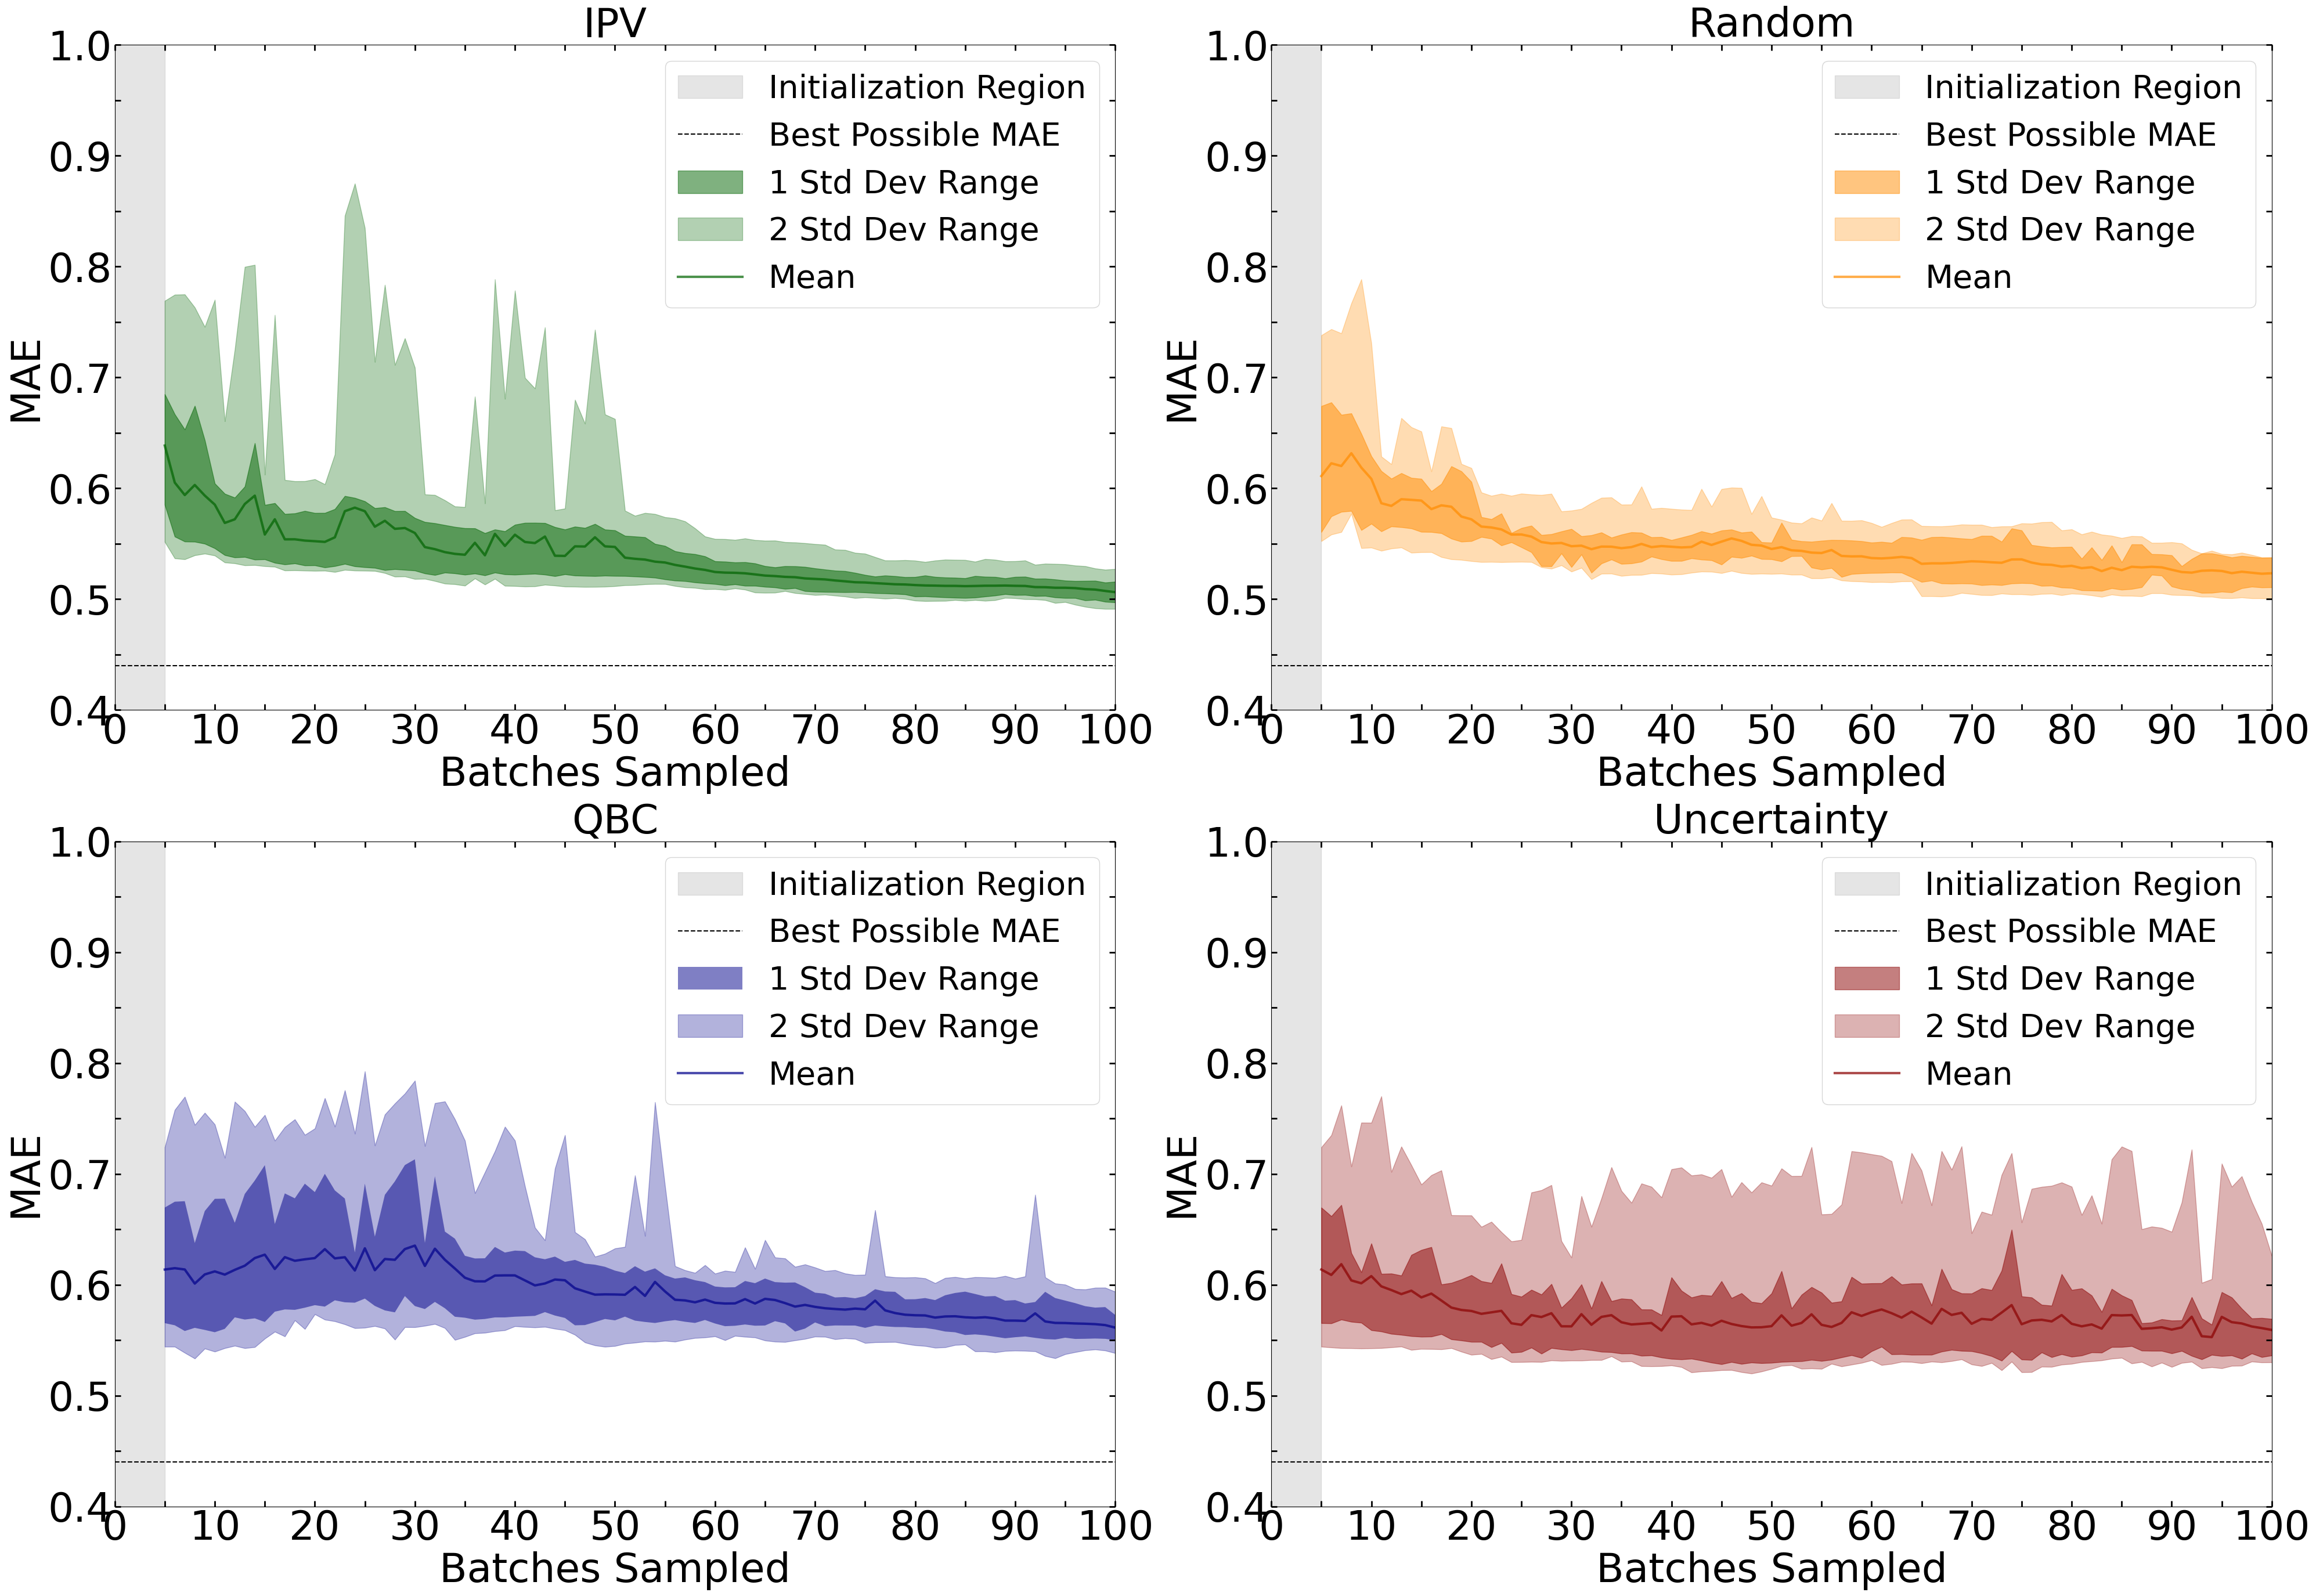

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(40, 30))
# fig.suptitle('MAE Across Different Sampling Strategies (NMR Dataset)',fontsize=50)
    
for ax in axs.flat:
    ax.axvspan(0, 5, color='gray', alpha=0.2, label='Initialization Region')
    ax.axhline(y=0.44, color='k', linestyle='--', label='Best Possible MAE')
    ax.set_xlim([0, 100])
    ax.set_ylim([0.4, 1.0])
    ax.tick_params(axis='both', which='both', direction='in',top=True,right=True,labelsize=50,length=7,width=2)
    ax.set_xticks(np.arange(0, 101, 10))
    ax.minorticks_on()
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator(2))
    ax.yaxis.set_minor_locator(ticker.AutoMinorLocator(2))
    ax.set_xlabel('Batches Sampled',fontsize=50)
    ax.set_ylabel('MAE',fontsize=50)
    ax.legend(fontsize=40)
    


axs[0, 0].fill_between(nmr_percent, np.percentile(nmr_qnipv_runs,15.9,axis=0),np.percentile(nmr_qnipv_runs,84.1,axis=0) , ec='none',color='darkgreen', alpha=0.5, label='1 Std Dev Range')
# axs[0,0].axhline(y=0.48, color='k', linestyle='--', label='Best MAE')
axs[0, 0].fill_between(nmr_percent,np.percentile(nmr_qnipv_runs,2.3,axis=0),np.percentile(nmr_qnipv_runs,97.7,axis=0), ec='none',color='darkgreen', alpha=0.3, label='2 Std Dev Range')
axs[0, 0].plot(nmr_percent, np.mean(nmr_qnipv_runs,axis=0), color='darkgreen',alpha=0.7, label='Mean',linewidth=3)
axs[0, 0].set_title('IPV',fontsize=50)
axs[0, 0].legend(fontsize=40)



axs[0, 1].fill_between(nmr_percent,np.percentile(nmr_random_runs,15.9,axis=0),np.percentile(nmr_random_runs,84.1,axis=0), ec='none',color='darkorange', alpha=0.5, label='1 Std Dev Range')
axs[0, 1].fill_between(nmr_percent, np.percentile(nmr_random_runs,2.3,axis=0),np.percentile(nmr_random_runs,97.7,axis=0), ec='none',color='darkorange', alpha=0.3, label='2 Std Dev Range')
axs[0,1].plot(nmr_percent, np.mean(nmr_random_runs,axis=0), color='darkorange',alpha=0.7, label='Mean',linewidth=3)
axs[0, 1].set_title('Random',fontsize=50)
axs[0, 1].legend(fontsize=40)



axs[1, 0].fill_between(nmr_percent, np.percentile(nmr_qbc_runs, 15.9,axis=0), np.percentile(nmr_qbc_runs, 84.1,axis=0), color='darkblue', alpha=0.5, label='1 Std Dev Range',ec = 'none')
axs[1, 0].fill_between(nmr_percent, np.percentile(nmr_qbc_runs, 2.3, axis=0),np.percentile(nmr_qbc_runs,97.7,axis =0),ec = 'none', color='darkblue', alpha=0.3, label='2 Std Dev Range')
axs[1,0].plot(nmr_percent, np.mean(nmr_qbc_runs,axis=0),color='darkblue',alpha=0.7, label='Mean',linewidth=3)
axs[1, 0].set_title('QBC',fontsize=50)
axs[1, 0].legend(fontsize=40)



axs[1, 1].fill_between(nmr_percent, np.percentile(nmr_uncr_runs,15.9,axis=0), np.percentile(nmr_uncr_runs,84.1,axis=0), ec='none',color='darkred', alpha=0.5, label='1 Std Dev Range')
axs[1, 1].fill_between(nmr_percent,np.percentile(nmr_uncr_runs,2.3,axis=0), np.percentile(nmr_uncr_runs,97.7,axis=0), ec='none',color='darkred', alpha=0.3, label='2 Std Dev Range')
axs[1, 1].plot(nmr_percent, np.mean(nmr_uncr_runs,axis=0), color='darkred',alpha=0.7, label='Mean',linewidth=3)
axs[1, 1].set_title('Uncertainty',fontsize=50)
axs[1, 1].legend(fontsize=40)


plt.tight_layout(rect=[0, 0.03, 1, 0.95])  
fig.savefig("figure_12.pdf", bbox_inches="tight")
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


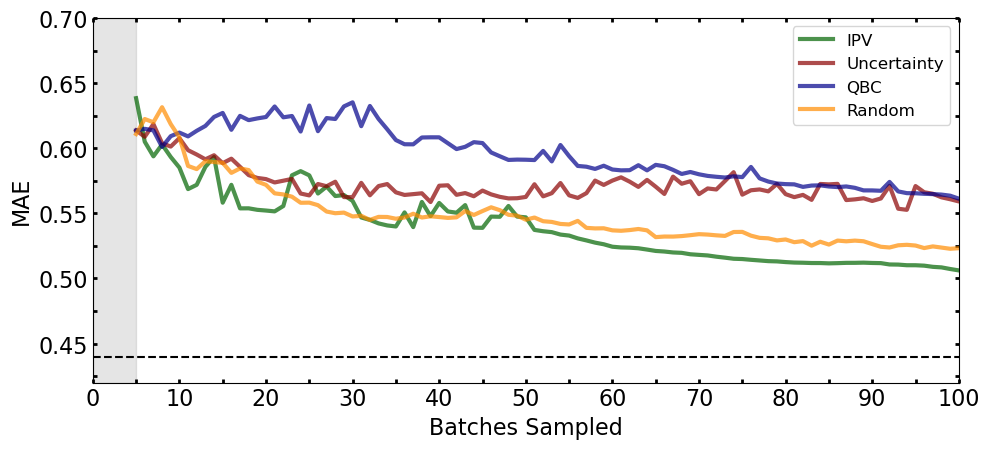

In [ ]:
fig, ax = plt.subplots(1, figsize=(10, 5))
# fig.suptitle('MAE Across Different Sampling Strategies (NMR Dataset)',fontsize=16)
ax.set_xlim([0, 100])
ax.set_ylim([0.42, 0.70])
ax.tick_params(axis='both', which='both', direction='in',top=True,right=True,labelsize=16,length=3,width=2)
ax.set_xticks(np.arange(0, 101, 10))
ax.minorticks_on()
ax.xaxis.set_minor_locator(ticker.AutoMinorLocator(2))
ax.yaxis.set_minor_locator(ticker.AutoMinorLocator(2))
ax.set_xlabel('Batches Sampled',fontsize=16)
ax.set_ylabel('MAE',fontsize=16)
ax.legend(fontsize=16)


plt.plot(nmr_percent, np.mean(nmr_qnipv_runs,axis=0), color='darkgreen',alpha=0.7, label='IPV',linewidth=3)

plt.legend(fontsize=12)
plt.plot(nmr_percent, np.mean(nmr_uncr_runs,axis=0), color='darkred',alpha=0.7, label='Uncertainty',linewidth=3)
plt.legend(fontsize=12)
plt.plot(nmr_percent, np.mean(nmr_qbc_runs,axis=0),color='darkblue',alpha=0.7, label='QBC',linewidth=3)
plt.plot(nmr_percent, np.mean(nmr_random_runs,axis=0), color='darkorange',alpha=0.7, label='Random',linewidth=3)
plt.legend(fontsize=12)
plt.axvspan(0, 5, color='gray', alpha=0.2, label='Initialization Region')
plt.axhline(y=0.44, color='k', linestyle='--', label='Best Possible MAE')

plt.tight_layout(rect=[0, 0.03, 1, 0.95]) 
fig.savefig("figure_13.pdf", bbox_inches="tight")
plt.show()


### AutoAM Dataset

In [9]:
len(am_percent)

68

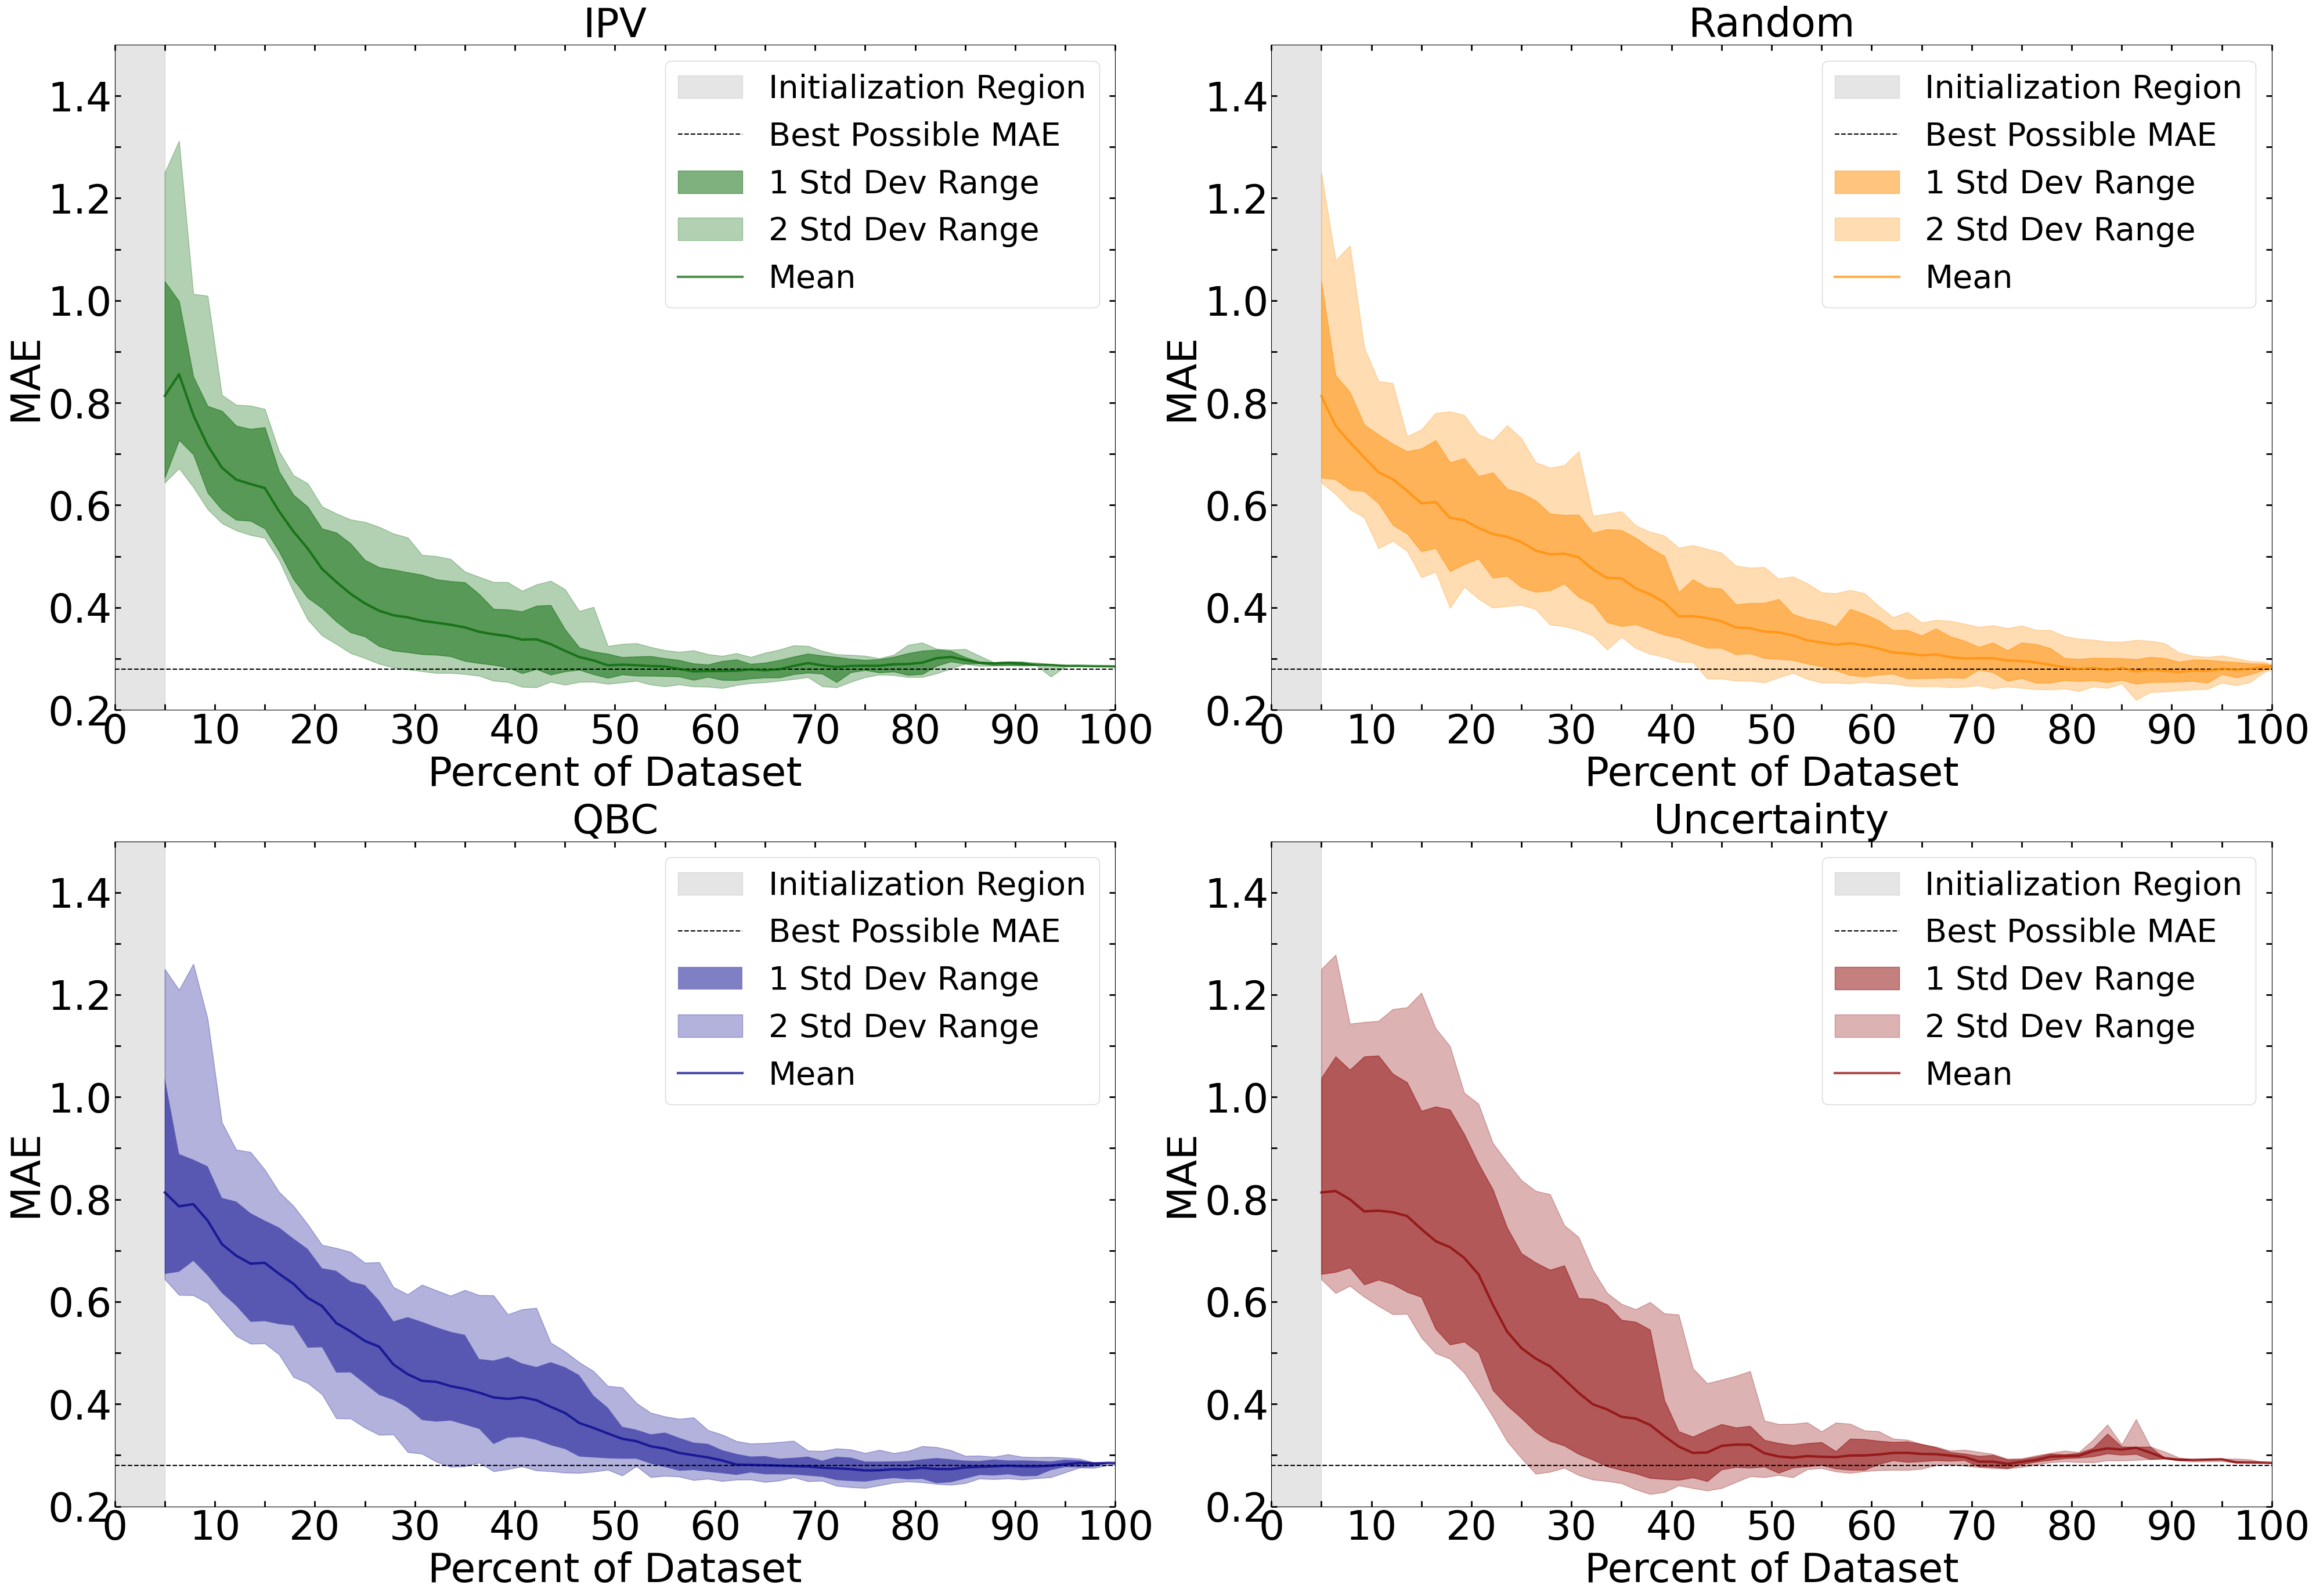

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(40, 30))
# fig.suptitle('MAE Across Different Sampling Strategies (AM Dataset)',fontsize=50)

    
for ax in axs.flat:
    ax.axvspan(0, 5, color='gray', alpha=0.2, label='Initialization Region')
    ax.axhline(y=0.28, color='k', linestyle='--', label='Best Possible MAE')
    ax.set_xlim([0, 100])
    ax.set_ylim([0.2, 1.5])
    ax.tick_params(axis='both', which='both', direction='in',top=True,right=True,labelsize=50,length=7,width=2)
    ax.set_xticks(np.arange(0, 101, 10))
    ax.minorticks_on()
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator(2))
    ax.yaxis.set_minor_locator(ticker.AutoMinorLocator(2))
    ax.set_xlabel('Percent of Dataset',fontsize=50)
    ax.set_ylabel('MAE',fontsize=50)
    ax.legend(fontsize=40)



for ax in axs.flat:
    ax.set_xticks(np.arange(0, 101, 10))


axs[0, 0].fill_between(am_percent, np.percentile(am_qnipv_runs,15.9,axis=0),np.percentile(am_qnipv_runs,84.1,axis=0) , ec='none',color='darkgreen', alpha=0.5, label='1 Std Dev Range')
# axs[0,0].axhline(y=0.48, color='k', linestyle='--', label='Best MAE')
axs[0, 0].fill_between(am_percent,np.percentile(am_qnipv_runs,2.3,axis=0),np.percentile(am_qnipv_runs,97.7,axis=0) , ec='none',color='darkgreen', alpha=0.3, label='2 Std Dev Range')
axs[0, 0].plot(am_percent, np.mean(am_qnipv_runs,axis=0), color='darkgreen',alpha=0.7, label='Mean',linewidth=3)
axs[0, 0].set_title('IPV',fontsize=50)
# axs[0, 0].set_xlabel('Percent of Dataset')
axs[0, 0].set_ylabel('MAE')
axs[0, 0].legend(fontsize=40)


axs[0, 1].fill_between(am_percent,np.percentile(am_random_runs,15.9,axis=0),np.percentile(am_random_runs,84.1,axis=0), ec='none',color='darkorange', alpha=0.5, label='1 Std Dev Range')
axs[0, 1].fill_between(am_percent, np.percentile(am_random_runs,2.3,axis=0),np.percentile(am_random_runs,97.7,axis=0), ec='none',color='darkorange', alpha=0.3, label='2 Std Dev Range')
axs[0,1].plot(am_percent, np.mean(am_random_runs,axis=0), color='darkorange',alpha=0.7, label='Mean',linewidth=3)
axs[0, 1].set_title('Random',fontsize=50)
axs[0, 1].set_ylabel('MAE')
axs[0, 1].legend(fontsize=40)



axs[1, 0].fill_between(am_percent, np.percentile(am_qbc_runs, 15.9,axis=0), np.percentile(am_qbc_runs, 84.1,axis=0), color='darkblue', alpha=0.5, label='1 Std Dev Range',ec = 'none')
axs[1, 0].fill_between(am_percent, np.percentile(am_qbc_runs, 2.3, axis=0),np.percentile(am_qbc_runs,97.7,axis =0),ec = 'none', color='darkblue', alpha=0.3, label='2 Std Dev Range')
axs[1,0].plot(am_percent, np.mean(am_qbc_runs,axis=0),color='darkblue',alpha=0.7, label='Mean',linewidth=3)
axs[1, 0].set_title('QBC',fontsize=50)
axs[1, 0].set_ylabel('MAE')
axs[1, 0].legend(fontsize=40)




axs[1, 1].fill_between(am_percent, np.percentile(am_unc_runs,15.9,axis=0), np.percentile(am_unc_runs,84.1,axis=0), ec='none',color='darkred', alpha=0.5, label='1 Std Dev Range')
axs[1, 1].fill_between(am_percent,np.percentile(am_unc_runs,2.3,axis=0), np.percentile(am_unc_runs,97.7,axis=0), ec='none',color='darkred', alpha=0.3, label='2 Std Dev Range')
axs[1, 1].plot(am_percent, np.mean(am_unc_runs,axis=0), color='darkred',alpha=0.7, label='Mean',linewidth=3)
axs[1, 1].set_title('Uncertainty',fontsize=50)
# axs[1, 1].set_xlabel('Percent of Dataset')
axs[1, 1].set_ylabel('MAE')
axs[1, 1].legend(fontsize=40)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  
fig.savefig("figure_8.pdf", bbox_inches="tight")
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


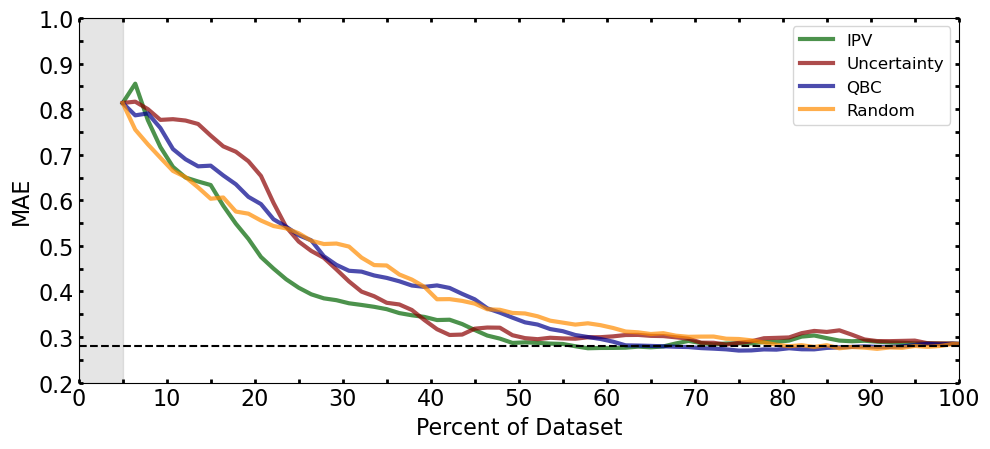

In [ ]:
fig, ax = plt.subplots(1, figsize=(10, 5))
# fig.suptitle('MAE Across Different Sampling Strategies (AM Dataset)',fontsize=16)

ax.set_xlim([0, 100])
ax.set_ylim([0.2, 1.0])
ax.tick_params(axis='both', which='both', direction='in',top=True,right=True,labelsize=16,length=3,width=2)
ax.set_xticks(np.arange(0, 101, 10))
ax.minorticks_on()
ax.xaxis.set_minor_locator(ticker.AutoMinorLocator(2))
ax.yaxis.set_minor_locator(ticker.AutoMinorLocator(2))
ax.set_xlabel('Percent of Dataset',fontsize=16)
ax.set_ylabel('MAE',fontsize=16)
ax.legend(fontsize=16)


plt.plot(am_percent, np.mean(am_qnipv_runs,axis=0), color='darkgreen',alpha=0.7, label='IPV',linewidth=3)
plt.legend(fontsize=12)
plt.plot(am_percent, np.mean(am_unc_runs,axis=0), color='darkred',alpha=0.7, label='Uncertainty',linewidth=3)
plt.legend(fontsize=12)
plt.plot(am_percent, np.mean(am_qbc_runs,axis=0),color='darkblue',alpha=0.7, label='QBC',linewidth=3)
plt.plot(am_percent, np.mean(am_random_runs,axis=0), color='darkorange',alpha=0.7, label='Random',linewidth=3)
plt.legend(fontsize=12)

plt.axvspan(0, 5, color='gray', alpha=0.2, label='Initialization Region')
plt.axhline(y=0.28, color='k', linestyle='--', label='Best Possible MAE')


plt.tight_layout(rect=[0, 0.03, 1, 0.95])  
fig.savefig("figure_9.pdf", bbox_inches="tight")
plt.show()

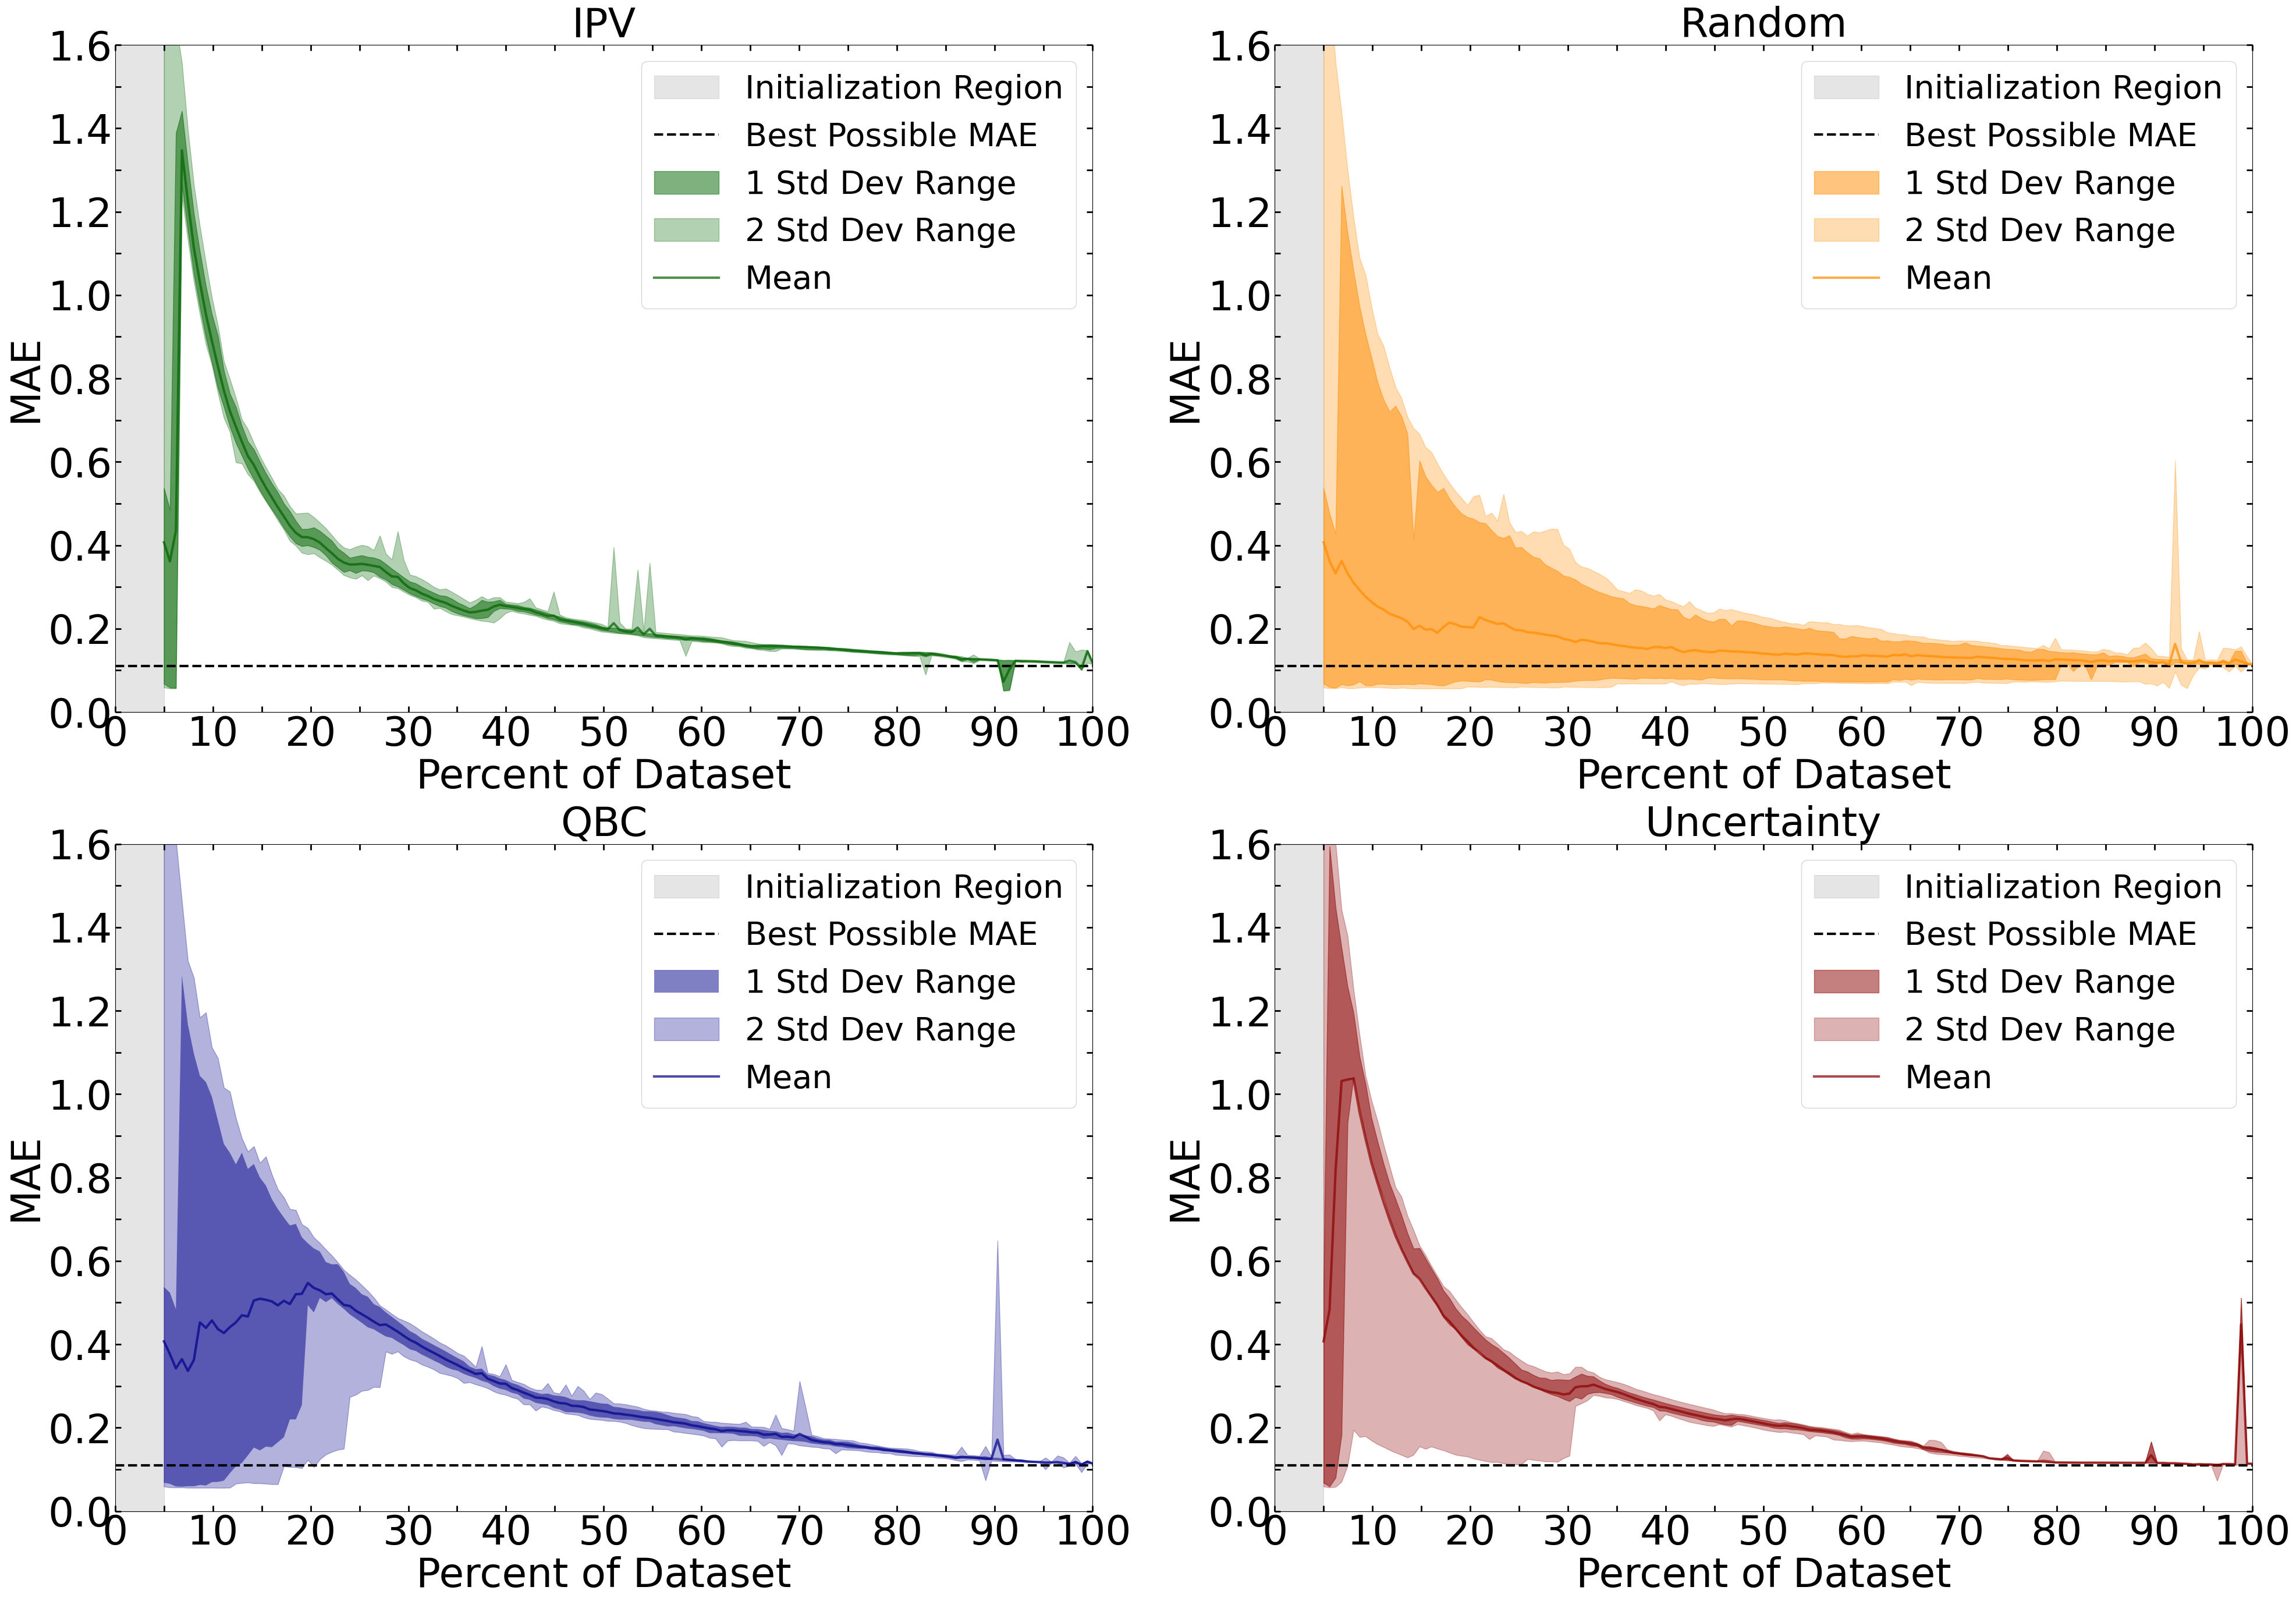

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(40, 30))
# fig.suptitle('MAE Across Different Sampling Strategies (Thermo Dataset)',fontsize=50)

for ax in axs.flat:
    ax.axvspan(0, 5, color='gray', alpha=0.2, label='Initialization Region')
    ax.axhline(y=0.11, color='k', linestyle='--', label='Best Possible MAE',linewidth=3)
    ax.set_xlim([0, 100])
    ax.set_ylim([0.0, 1.6])
    ax.tick_params(axis='both', which='both', direction='in',top=True,right=True,labelsize=50,length=7,width=2)
    ax.set_xticks(np.arange(0, 101, 10))
    ax.minorticks_on()
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator(2))
    ax.yaxis.set_minor_locator(ticker.AutoMinorLocator(2))
    ax.set_xlabel('Percent of Dataset',fontsize=50)
    ax.set_ylabel('MAE',fontsize=50)
    ax.legend(fontsize=40)


axs[0, 0].fill_between(thermo_percent, np.percentile(thermo_qnipv_runs,15.9,axis=0),np.percentile(thermo_qnipv_runs,84.1,axis=0) , ec='none',color='darkgreen', alpha=0.5, label='1 Std Dev Range')
# axs[0,0].axhline(y=0.48, color='k', linestyle='--', label='Best MAE')
axs[0, 0].fill_between(thermo_percent,np.percentile(thermo_qnipv_runs,2.3,axis=0),np.percentile(thermo_qnipv_runs,97.7,axis=0) , ec='none',color='darkgreen', alpha=0.3, label='2 Std Dev Range')
axs[0, 0].plot(thermo_percent, np.mean(thermo_qnipv_runs,axis=0), color='darkgreen',alpha=0.7, label='Mean',linewidth=3)
axs[0, 0].set_title('IPV',fontsize=50)
# axs[0, 0].set_xlabel('Percent of Dataset')
axs[0, 0].set_ylabel('MAE')
axs[0, 0].legend(fontsize=40)


axs[0, 1].fill_between(thermo_percent,np.percentile(thermo_random,15.9,axis=0),np.percentile(thermo_random,84.1,axis=0), ec='none',color='darkorange', alpha=0.5, label='1 Std Dev Range')
axs[0, 1].fill_between(thermo_percent, np.percentile(thermo_random,2.3,axis=0),np.percentile(thermo_random,97.7,axis=0), ec='none',color='darkorange', alpha=0.3, label='2 Std Dev Range')
axs[0,1].plot(thermo_percent, np.mean(thermo_random,axis=0), color='darkorange',alpha=0.7, label='Mean',linewidth=3)
axs[0, 1].set_title('Random',fontsize=50)
axs[0, 1].set_ylabel('MAE')
axs[0, 1].legend(fontsize=40)


axs[1, 0].fill_between(thermo_percent, np.percentile(thermo_qbc_runs, 15.9,axis=0), np.percentile(thermo_qbc_runs, 84.1,axis=0), color='darkblue', alpha=0.5, label='1 Std Dev Range',ec = 'none')
axs[1, 0].fill_between(thermo_percent, np.percentile(thermo_qbc_runs, 2.3, axis=0),np.percentile(thermo_qbc_runs,97.7,axis =0),ec = 'none', color='darkblue', alpha=0.3, label='2 Std Dev Range')
axs[1,0].plot(thermo_percent, np.mean(thermo_qbc_runs,axis=0),color='darkblue',alpha=0.7, label='Mean',linewidth=3)
axs[1, 0].set_title('QBC',fontsize=50)
axs[1, 0].set_ylabel('MAE')
axs[1, 0].legend(fontsize=40)


axs[1, 1].fill_between(thermo_percent, np.percentile(thermo_uncertainty,15.9,axis=0), np.percentile(thermo_uncertainty,84.1,axis=0), ec='none',color='darkred', alpha=0.5, label='1 Std Dev Range')
axs[1, 1].fill_between(thermo_percent,np.percentile(thermo_uncertainty,2.3,axis=0), np.percentile(thermo_uncertainty,97.7,axis=0), ec='none',color='darkred', alpha=0.3, label='2 Std Dev Range')
axs[1, 1].plot(thermo_percent, np.mean(thermo_uncertainty,axis=0), color='darkred',alpha=0.7, label='Mean',linewidth=3)
axs[1, 1].set_title('Uncertainty',fontsize=50)
# axs[1, 1].set_xlabel('Percent of Dataset')
axs[1, 1].set_ylabel('MAE')
axs[1, 1].legend(fontsize=40)

plt.tight_layout(rect=[0, 0.03, 1, 0.95]) 
fig.savefig("figure_10.pdf", bbox_inches="tight")
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


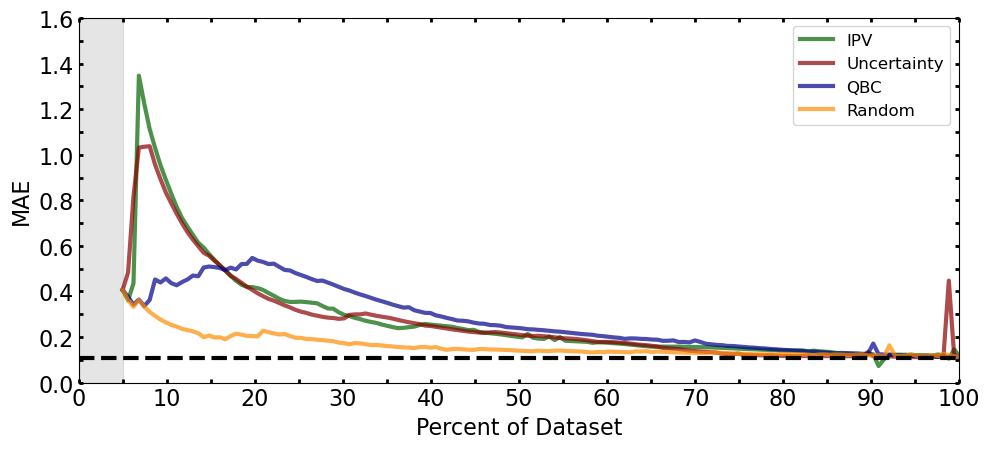

In [ ]:
fig, ax = plt.subplots(1, figsize=(10, 5))
# fig.suptitle('MAE Across Different Sampling Strategies (Thermo Dataset)',fontsize=16)

ax.set_xlim([0, 100])
ax.set_ylim([0.0, 1.6])
ax.tick_params(axis='both', which='both', direction='in',top=True,right=True,labelsize=16,length=3,width=2)
ax.set_xticks(np.arange(0, 101, 10))
ax.minorticks_on()
ax.xaxis.set_minor_locator(ticker.AutoMinorLocator(2))
ax.yaxis.set_minor_locator(ticker.AutoMinorLocator(2))
ax.set_xlabel('Percent of Dataset',fontsize=16)
ax.set_ylabel('MAE',fontsize=16)
ax.legend(fontsize=16)


plt.plot(thermo_percent, np.mean(thermo_qnipv_runs,axis=0), color='darkgreen',alpha=0.7, label='IPV',linewidth=3)
plt.legend(fontsize=12)
plt.plot(thermo_percent, np.mean(thermo_uncertainty,axis=0), color='darkred',alpha=0.7, label='Uncertainty',linewidth=3)
plt.legend(fontsize=12)
plt.plot(thermo_percent, np.mean(thermo_qbc_runs,axis=0),color='darkblue',alpha=0.7, label='QBC',linewidth=3)
plt.plot(thermo_percent, np.mean(thermo_random,axis=0), color='darkorange',alpha=0.7, label='Random',linewidth=3)
plt.legend(fontsize=12)

plt.axvspan(0, 5, color='gray', alpha=0.2, label='Initialization Region')
plt.axhline(y=0.11, color='k', linestyle='--', label='Best Possible MAE',linewidth=3)

    
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  
fig.savefig("figure_11.pdf", bbox_inches="tight")
plt.show()

### Plot of time for NMR dataset

In [18]:
timing_uncr_nmr = np.load('timing_uncertainty_nmr.npy').reshape(-1)
timing_qnipv_nmr = np.load('timing_qnipv_nmr.npy').reshape(-1)
timing_random_nmr = np.load('timing_random_nmr.npy').reshape(-1)
timing_qbc_nmr = np.load('timing_qbc_nmr.npy').reshape(-1)

In [19]:
iterations = np.linspace(0, 100, 100)
iterations.shape

(100,)

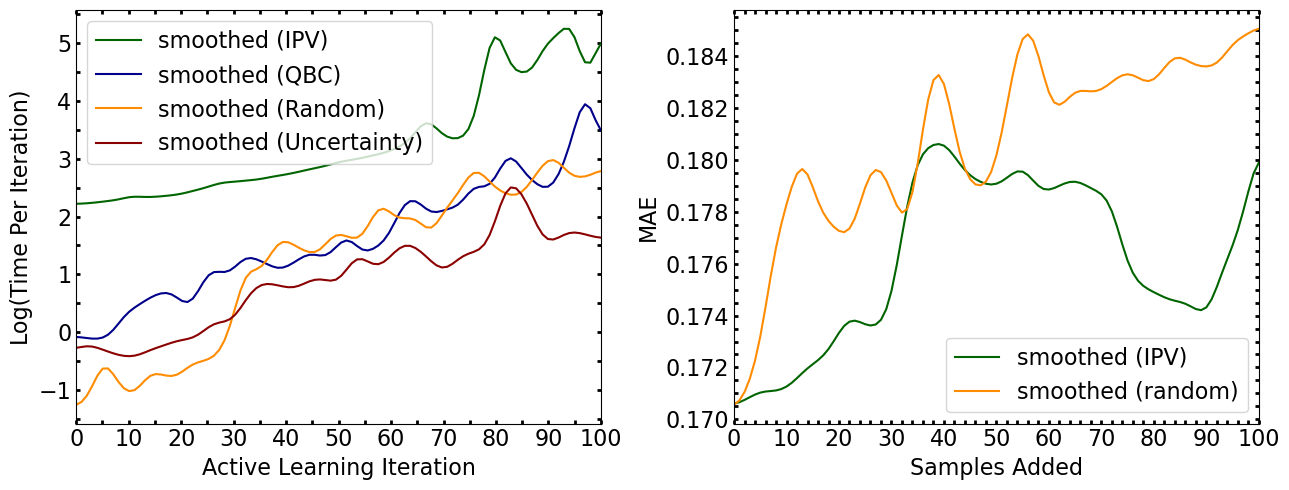

In [ ]:
random_mae_np = np.load('data_agg_random_thermo_dataset.npy')
qnipv_dataagg = np.load('dataagg_thermo_qnipv.npy')
qnipv_np = qnipv_dataagg.reshape(-1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 5))

smoothed_qnipv = gaussian_filter1d(np.log(timing_qnipv_nmr), sigma=2)
smoothed_qbc = gaussian_filter1d(np.log(timing_qbc_nmr), sigma=2)
smoothed_rand = gaussian_filter1d(np.log(timing_random_nmr), sigma=2)
smoothed_uncer = gaussian_filter1d(np.log(timing_uncr_nmr), sigma=2)

ax1.plot(iterations, smoothed_qnipv, label="smoothed (IPV)", color="darkgreen")
ax1.plot(iterations, smoothed_qbc, label="smoothed (QBC)", color="darkblue")
ax1.plot(iterations, smoothed_rand, label="smoothed (Random)", color="darkorange")
ax1.plot(iterations, smoothed_uncer, label="smoothed (Uncertainty)", color="darkred")
ax1.set_xlabel("Active Learning Iteration", size=16)
ax1.set_ylabel("Log(Time Per Iteration)", size=16)
ax1.set_xlim([0, 100])
ax1.tick_params(axis='both', which='both', direction='in', top=True, right=True,labelsize=16,length=3,width=2)
ax1.set_xticks(np.arange(0, 101, 10))
ax1.minorticks_on()
ax1.xaxis.set_minor_locator(ticker.AutoMinorLocator(2))
ax1.yaxis.set_minor_locator(ticker.AutoMinorLocator(2))
# ax1.set_title("Log(Time) Per Active Learning Cycle (NMR Dataset)", size=12)
ax1.legend(fontsize=16)

ax2.plot(np.linspace(0,100,101), gaussian_filter1d(qnipv_np, sigma=2), 
         label='smoothed (IPV)', color='darkgreen')
ax2.plot(np.linspace(0,100,101), gaussian_filter1d(random_mae_np, sigma=2), 
         label='smoothed (random)', color='darkorange')

ax2.tick_params(axis='both', which='both', direction='in', top=True, right=True,labelsize=16,length=3,width=2)
ax2.minorticks_on()
ax2.set_xlim(0, 100)
ax2.set_xticks(np.arange(0, 101, 10))
ax2.set_xlabel('Samples Added', size=16)
ax2.set_ylabel('MAE', size=16)
# ax2.set_title('Data Aggregation Using qNIPV (Thermal Conductivity Dataset)')
ax2.legend(fontsize=16)

plt.tight_layout()
fig.savefig("figure_14.pdf", bbox_inches="tight")
plt.show()

In [ ]:

import random
from sklearn.datasets import make_blobs, make_regression
import seaborn as sns
from scipy.stats import gaussian_kde
random.seed(42)

x1, y1 = make_blobs(n_samples=5000, centers=3, n_features=10, random_state=150)

In [5]:
xlower_bounds = x1.min(axis=0)
xupper_bounds = x1.max(axis=0)

xlower_bounds = torch.tensor(xlower_bounds, dtype=torch.double)
xupper_bounds = torch.tensor(xupper_bounds, dtype=torch.double)

xbounds = torch.stack([xlower_bounds, xupper_bounds])
xbounds

#convert array to tensor
x = torch.tensor(x1, dtype=torch.double)
y = torch.tensor(y1, dtype=torch.double)


x = normalize(x, bounds=xbounds)  
y = standardize(y)


In [6]:
x_candidates, x_test, y_candidates, y_test = train_test_split(x, y, test_size=0.20, random_state=300)

xtest = torch.tensor(x_test, dtype=torch.double)
ytest = torch.tensor(y_test, dtype=torch.double)

xcandidates_original = torch.tensor(x_candidates, dtype=torch.double)
ycandidates_original = torch.tensor(y_candidates, dtype=torch.double)

In [7]:
bnds = torch.tensor([[0,0,0,0,0,0,0,0,0,0], [1,1,1,1,1,1,1,1,1,1]], dtype=torch.double)
bounds = torch.tensor(bnds, dtype=torch.double)
bounds

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]], dtype=torch.float64)

In [53]:
from botorch.utils.sampling import draw_sobol_samples

mcp = draw_sobol_samples(bounds=bounds, n=1024, q=1, seed=300).squeeze(1)
mcp.shape

torch.Size([1024, 10])

In [8]:
def random_initial_data(x, y, initial_percent, seed):
    np.random.seed(seed)
    n = int(x.shape[0]*initial_percent)
    idx = np.random.choice(x.shape[0], n, replace=False)
    x_initial = x[idx]
    y_initial = y[idx]
    x_candidates = np.delete(x, idx, axis=0)
    y_candidates = np.delete(y, idx, axis=0)
    return x_initial, y_initial, x_candidates, y_candidates

In [9]:
xcandidates = xcandidates_original.clone()
ycandidates = ycandidates_original.clone()

In [10]:
ycandidates = ycandidates.unsqueeze(-1)
ycandidates.shape

torch.Size([4000, 1])

In [ ]:
gp = SingleTaskGP(xcandidates, ycandidates) 
mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
fit_gpytorch_mll(mll)

ypred = gp(xtest)
ypred_mean = ypred.mean.detach().numpy()

ymae = mean_absolute_error(ytest, ypred_mean)
ymae

In [ ]:
import time


timing_results = []

candidate_sizes = [100, 500, 1000, 4000]
mcp_points = [256, 512, 1024, 2048]

for n_cand in tqdm(candidate_sizes, desc="Candidate sizes"):
    xcandidates = xcandidates_original[:n_cand].clone()
    ycandidates = ycandidates_original[:n_cand].clone()
    
    xinit, yinit, xcandidates, ycandidates = random_initial_data(
        xcandidates, ycandidates, 0.05, seed=n_cand
    )
    yinit = yinit.unsqueeze(-1)
    
    gp = SingleTaskGP(xinit, yinit)
    mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
    fit_gpytorch_mll(mll)
    
    for mcp_size in tqdm(mcp_points, desc=f"  MC points (n_cand={n_cand})", leave=False):
        
        mcp = draw_sobol_samples(bounds=bounds, n=mcp_size, q=1).squeeze(1)
        
        start_time = time.time()
        
        qNIPV = qNegIntegratedPosteriorVariance(gp, mc_points=mcp)
        
        acq_vals = []
        for x_cand in xcandidates:
            x_tensor = x_cand.unsqueeze(0)
            nipv_val = qNIPV(x_tensor)
            acq_vals.append(nipv_val.item())
        
        elapsed_time = time.time() - start_time
        
        timing_results.append({
            'n_candidates': n_cand,
            'n_mc': mcp_size,
            'time_sec': elapsed_time
        })
        
        print(f" n_cand={n_cand:5d}, n_mc={mcp_size:4d}: {elapsed_time:7.3f}s")


df_timing = pd.DataFrame(timing_results)

pivot_table = df_timing.pivot(index='n_candidates', columns='n_mc', values='time_sec')
print("\n" + "="*80)
print("NIPV COMPUTATION TIME (seconds)")
print("="*80)
print(pivot_table.to_string(float_format=lambda x: f'{x:.2f}'))

Candidate sizes:   0%|          | 0/4 [00:00<?, ?it/s]

 n_cand=  100, n_mc= 256:   0.286s


 n_cand=  100, n_mc= 512:   0.534s


 n_cand=  100, n_mc=1024:   0.919s


Candidate sizes:  25%|██▌       | 1/4 [00:04<00:13,  4.50s/it]

 n_cand=  100, n_mc=2048:   2.719s


 n_cand=  500, n_mc= 256:   1.471s


 n_cand=  500, n_mc= 512:   2.267s


 n_cand=  500, n_mc=1024:   4.667s


Candidate sizes:  50%|█████     | 2/4 [00:26<00:29, 14.58s/it]

 n_cand=  500, n_mc=2048:  13.127s


 n_cand= 1000, n_mc= 256:   3.171s


 n_cand= 1000, n_mc= 512:   4.951s


 n_cand= 1000, n_mc=1024:   9.602s


Candidate sizes:  75%|███████▌  | 3/4 [01:11<00:28, 28.52s/it]

 n_cand= 1000, n_mc=2048:  27.276s


 n_cand= 4000, n_mc= 256:  16.942s


 n_cand= 4000, n_mc= 512:  22.974s


 n_cand= 4000, n_mc=1024:  45.026s


Candidate sizes: 100%|██████████| 4/4 [04:33<00:00, 68.29s/it]

 n_cand= 4000, n_mc=2048: 116.688s

NIPV COMPUTATION TIME (seconds)
n_mc          256   512   1024   2048
n_candidates                         
100           0.29  0.53  0.92   2.72
500           1.47  2.27  4.67  13.13
1000          3.17  4.95  9.60  27.28
4000         16.94 22.97 45.03 116.69
